In [12]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [13]:
df = pd.read_csv('tripdata.csv')
# filling up the missing values in member_birth_year with mean of Ages
df['member_birth_year'].fillna((df['member_birth_year'].mean()), inplace=True)

# filling up the missing values in member_gender with mode of Genders
df['member_gender'].fillna((df['member_gender'].mode()), inplace=True)

#checking number of cells with NaN values again
sum(df.isnull().values.ravel())
#droping rows with NaN values as they are empty rows at the end of the sheet
df.dropna(inplace=True)

#checking number of cells with NaN values again
sum(df.isnull().values.ravel())

0

### Dataset Overview
There are 174952 bike trip records with 10 features (Duration, Start Time, End Time ,Start Location, End Location, Age, User Type, Gender, Bike Share Statues)

Most variable are numeric but the variables Gender, User Type, and Bike Share Statues are qualitative

Gender: Male, Female, Other

User Type: Customer, Subscriber

Bike Share Statues: Yes, No

In [14]:
# descriptive statistics for numeric variables
df.describe()

duration_sec  start_station_id  start_station_latitude  \
count  174952.000000     174952.000000           174952.000000   
mean      704.002744        139.002126               37.771220   
std      1642.204905        111.648819                0.100391   
min        61.000000          3.000000               37.317298   
25%       323.000000         47.000000               37.770407   
50%       510.000000        104.000000               37.780760   
75%       789.000000        239.000000               37.797320   
max     84548.000000        398.000000               37.880222   

       start_station_longitude  end_station_id  end_station_latitude  \
count            174952.000000   174952.000000         174952.000000   
mean               -122.351760      136.604486             37.771414   
std                   0.117732      111.335635              0.100295   
min                -122.453704        3.000000             37.317298   
25%                -122.411901       44.000000             37.770407   
50%                -122.398279      101.000000             37.781010   
75%                -122.283093      238.000000             37.797673   
max                -121.874119      398.000000             37.880222   

       end_station_longitude        bike_id  member_birth_year  
count          174952.000000  174952.000000      174952.000000  
mean             -122.351335    4482.587555        1984.803135  
std                 0.117294    1659.195937          10.118731  
min              -122.453704      11.000000        1878.000000  
25%              -122.411647    3799.000000        1980.000000  
50%              -122.397437    4960.000000        1987.000000  
75%              -122.286533    5505.000000        1992.000000  
max              -121.874119    6645.000000        2001.000000

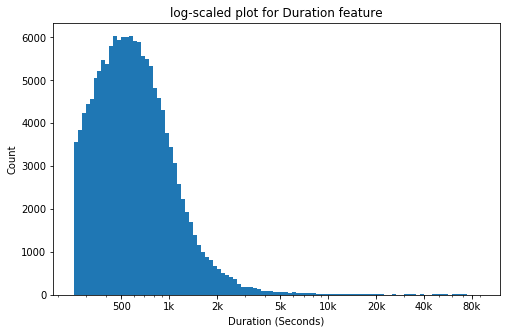

In [15]:
# there's a long tail in the distribution and huge outliers, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4, 4e4, 8e4], [500, '1k', '2k', '5k', '10k', '20k', '40k', '80k'])
plt.xlabel('Duration (Seconds)')
plt.ylabel('Count')
plt.title('log-scaled plot for Duration feature')
plt.show()

Duration has a long tailed distribution and huge outliers. When plotted on a log scale, the diagram is positively (right) skewed, and has a starting value of 61 seconds, it has a peak around the 700 seconds. There is an expected fall for the values as the duration increases.

Next up, the first predictor variable of interest: Age.

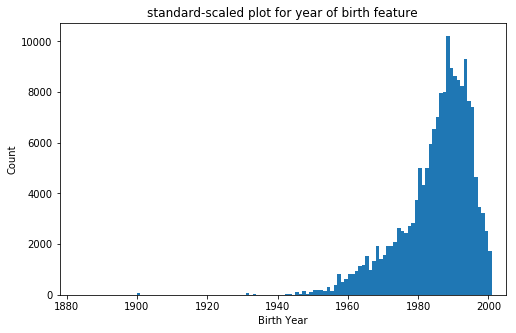

In [16]:
# plotting age on a standard scale
binsize = 1
bins = np.arange(0, df['member_birth_year'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'member_birth_year', bins = bins)
plt.xlim([1878,2005])
plt.xlabel('Birth Year')
plt.ylabel('Count')
plt.title('standard-scaled plot for year of birth feature')
plt.show()

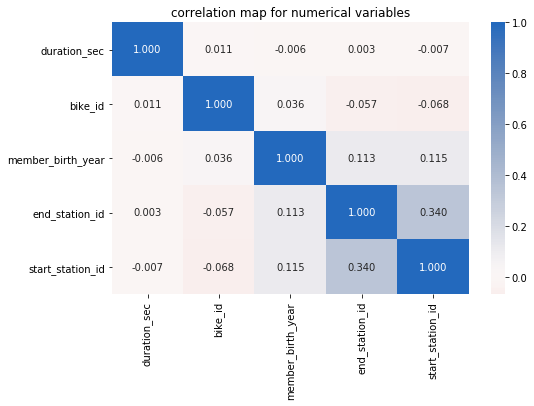

In [17]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.title('correlation map for numerical variables')
plt.show()

Surprisingly, there are no strong correlations in the dataset between the quantitiative variables. I won't perform further analysis with these variables as they seem of less interest to get insights.

Now, let's move to the categorical data and how they relate to the price

In [18]:
# select outliers, using criteria eyeballed from the plots

start_outliers = ((df['start_station_latitude'] < 37.6) | (df['start_station_longitude'] > -122))
end_outliers = ((df['end_station_latitude'] < 37.6) | (df['end_station_longitude'] > -122))

# calculating upper bound for duration to opt outliers out: Q3 + 1.5×IQR
# there are no outliers lower than the lower bound as it's in the negatives
duration_outliers = ((df['duration_sec'] > 1488))


print(start_outliers.sum())
print(end_outliers.sum())
print(duration_outliers.sum())

# remove rows with outliers
df = df.loc[-start_outliers & -duration_outliers & -end_outliers,:]



7961
7962
9328


C:\Users\Adel\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


<Figure size 720x720 with 0 Axes>

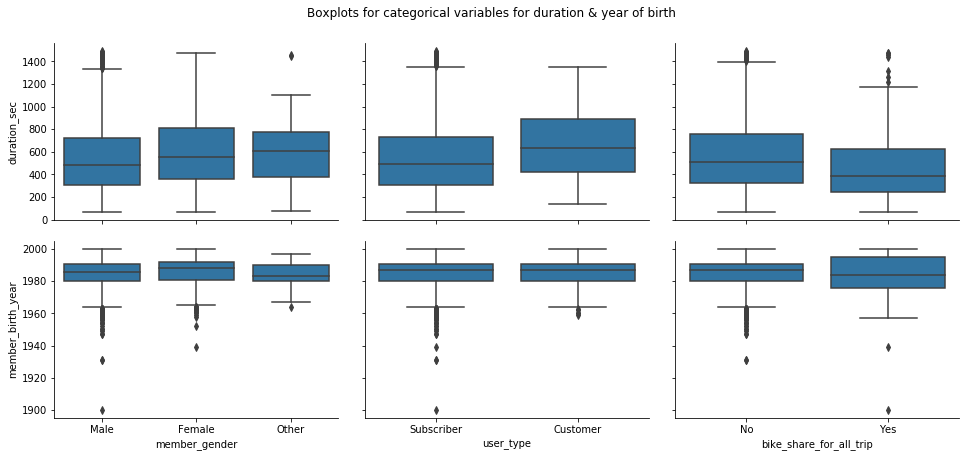

In [19]:
# plot matrix of numeric features against categorical features.
# can use a larger sample since there are fewer plots and they're simpler in nature.

samples = np.random.choice(df.shape[0], 2000, replace = False)
df_samp = df.loc[samples,:]

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, y_vars = ['duration_sec', 'member_birth_year'], x_vars = categoric_vars,
                size = 3, aspect = 1.5)
g.map(boxgrid)

plt.suptitle('Boxplots for categorical variables for duration & year of birth').set_position([.5, 1.05])

plt.show();



There is an interesting relationship betwwen User type and the duration, it appears that being a subscriber doesn't imply spending more time. Same with bike sharing status, it's inversely related to the duration of the trip. Females spend more time more than males and other genders. These will be further investigated in the following.

Let's take a look on the relationships betwwen the the categorical data:

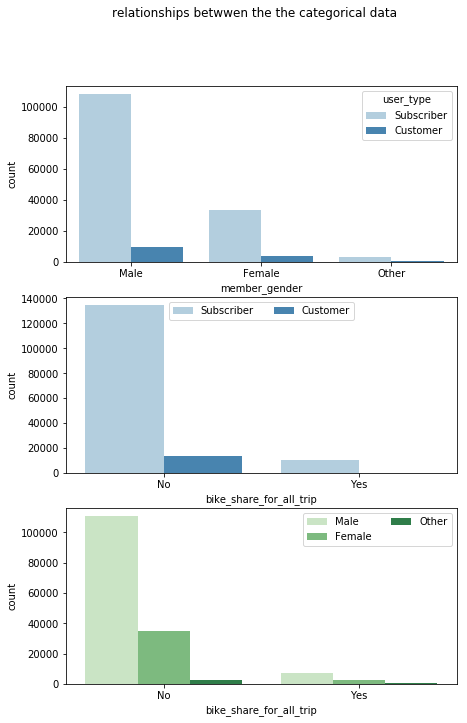

In [20]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [7, 11])

# subplot 1: Member gender vs User Type
plt.subplot(3, 1, 1)
sb.countplot(data = df, x = 'member_gender', hue = 'user_type', palette = 'Blues')

# subplot 2: Bike Sharing Status vs. User Type
ax = plt.subplot(3, 1, 2)
sb.countplot(data = df, x = 'bike_share_for_all_trip', hue = 'user_type', palette = 'Blues')
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping

# subplot 3: Bike Sharing Status vs. Member Gender, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = df, x = 'bike_share_for_all_trip', hue = 'member_gender', palette = 'Greens')
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping

plt.suptitle('relationships betwwen the the categorical data')
plt.show()

There are interesting findings that:

Majority of males tend to subscribe
Customers are not at all sharing the bikes
Majority of users tend not to use the sharing option whatever the gender
Now let's take a look on the replationship between duration and categorical data in more details

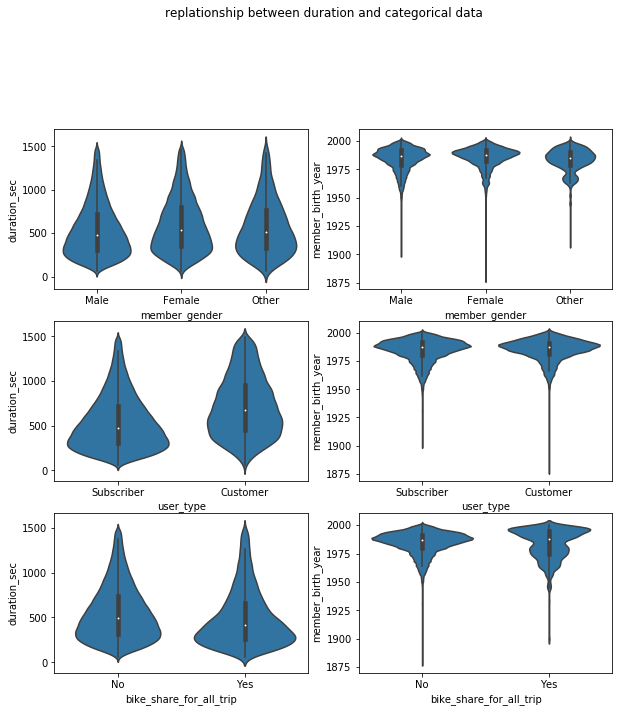

In [21]:
# plot the categorical variables against duration and birth year again, this time with full data 
fig, ax = plt.subplots(ncols = 2, nrows = 3 , figsize = [10,10])

for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    sb.violinplot(data = df, x = var, y = 'duration_sec', ax = ax[i,0],
               color = default_color)
    
    sb.violinplot(data = df, x = var, y = 'member_birth_year', ax = ax[i,1],
               color = default_color)
    
plt.suptitle('replationship between duration and categorical data').set_position([.5, 1.05])

plt.show()

As expected, factoring in the categorical variabels did not change or give inshights about the relationship between the duration and year of birth. Thus, leading to no benefecial insights out of this multivariable expolration